In [ ]:
# test the logging functionality of pyLog
import numpy as np
from pyArena import pyLog

kwargsLog = {'nx': 3, 'nu': 2}

sysLog  = pyLog(**kwargsLog)

print('-----Initialization of pyLog-----')
print('1. State: {}'.format(sysLog.stateTrajectory))
print('2. Input: {}'.format(sysLog.inputTrajectory))
print('3. Time: {}'.format(sysLog.time))

xTemp = np.array([1,2,3])
uTemp = np.array([10,20])
tTemp = 0

sysLog.updateLog(tTemp,xTemp,uTemp)

print('-----First update of pyLog-----')
print('1. State: {}'.format(sysLog.stateTrajectory))
print('2. Input: {}'.format(sysLog.inputTrajectory))
print('3. Time: {}'.format(sysLog.time))

xTemp = np.array([10,20,30])
uTemp = np.array([100,200])
tTemp = 1

sysLog.updateLog(tTemp,xTemp,uTemp)

print('-----Second update of pyLog-----')
print('1. State: {}'.format(sysLog.stateTrajectory))
print('2. Input: {}'.format(sysLog.inputTrajectory))
print('3. Time: {}'.format(sysLog.time))

sysLog.reshapeLog()

print('-----After reshape of pyLog-----')
print('1. State: {}'.format(sysLog.stateTrajectory))
print('2. Input: {}'.format(sysLog.inputTrajectory))
print('3. Time: {}'.format(sysLog.time))

In [1]:
# test the functionality of pyArena
import numpy as np
from pyArena import pyArena

# Specify simulation parameters
nx = 4 
nu = 3
Tsim = 100
dt = 0.05
K = np.eye(2)
eps = np.array([0.1, 0])
vd = 1

# Specify desired path
radius = 10
a = 0.1

pd = lambda l: np.array([radius*np.sin(a*l), radius*np.cos(a*l)])

# TODO: Learn Symbolic operations in Python
pdD = lambda l: np.array([a*radius*np.cos(a*l), -a*radius*np.sin(a*l)])

## Create a path following controller class
class PathFollowing:
    def __init__(self, **kwargs):
        self.funpd = kwargs['pd']
        self.funpdD = kwargs['pdD']
        self.K = kwargs['gain']
        self.eps = kwargs['eps']
        self.vd = kwargs['vd']
        self.invDelta = np.linalg.pinv(np.array([[1.0, eps[1]], [0.0, eps[0]]]))
    
    def computeInput(self, t, x):
        p = x[0:1]
        theta = x[2]
        gamma = x[3]
        
        pd = self.funpd(gamma)
        pdDot = self.funpdD(gamma)*self.vd
        
        R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
        
        e = R.T@(p - pd) + eps
    
        u_ff = R.T@pdDot
    
        u = -K@e + u_ff
    
        g_err = 0 # TODO: make the modifications
    
        gamma_dot = vd + g_err
        
        return np.append(u, gamma_dot)


kwargsController = {'pd': pd, 'pdD': pdD, 'gain': K, 'eps': eps, 'vd': vd}
controller = PathFollowing(**kwargsController)
        

In [2]:
# create a system class
class DynamicalSystem:
    def __init__(self, **kwargs):
        self.nx = kwargs['nx']
        self.nu = kwargs['nu']
        self.stateEquation = kwargs['stateEquation']
        self.isMeasurementEquation = False
        self.initialCondition = kwargs['initialCondition']
        self.controller = kwargs['controller']

# Initial Condition
x_init = np.array([10.0, 0.0, 0.0, 0.0])

# Specify robot kinematics
def unicycle(t, x, u):
    return np.array([u[0]*np.cos(x[2]), u[0]*np.sin(x[2]), u[1], u[2]])

kwargsSystem = {'nx':nx, 'nu':nu,\
                'stateEquation': lambda t,x,u: unicycle(t,x,u),\
                'initialCondition': x_init, 'controller': controller}

system = DynamicalSystem(**kwargsSystem)


In [3]:
kwargsSimulation = {'system': system, 'simTime': Tsim, 'dt': dt}
pyA = pyArena(**kwargsSimulation)

dataLog = pyA.run()


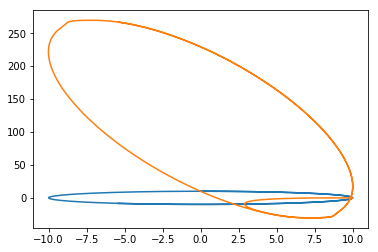

In [5]:
## Plot data
import matplotlib.pyplot as plt

pdVec = pd(np.linspace(0,100,1000))
plt.plot(pdVec[0,:], pdVec[1,:])
plt.plot(dataLog.stateTrajectory[:,0], dataLog.stateTrajectory[:,1])
plt.show()

#plt.plot(dataLog.time, pd)
#plt.plot(dataLog.time, dataLog.stateTrajectory[:,1])

